In [1]:
import tensorflow as tf
from tensorflow import keras 
import os
import model as unet_model
import math

# Data Display 
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

In [2]:
# Global Constants
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
CHANNELS = 3
BATCH_SIZE = 2
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512

# File Paths, data must be seperated into images and masks folders within the overall data folder
image_path = os.path.join("data", "images")
mask_path = os.path.join("data", "masks")

## The arguments for keras image data generator functions
# For the training and validation sets
TRAIN_ARGS = dict(
    rescale=1.0/255,        # Rescaling factor, applied after all other transformations
    shear_range=0.1,        # Shear the Image by 10%
    zoom_range=0.1,         # Zoom in or out by 10%
    horizontal_flip=True,   # Randomly flip horizontally
    vertical_flip=True,     # Randomly flip vertically
    fill_mode='nearest',    # Fill gaps with nears pixel
    validation_split=0.2)   # Reserve 20% for 'validation' (testing)

# For the testing split
TEST_ARGS = dict(
    rescale=1.0/255,        
    validation_split=0.2) 

# Arguments for the flow from directory function call for training
IMAGE_LOAD_TRAIN_ARGS = dict(
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    interpolation="nearest",
    subset='training',
    class_mode=None,
    seed=42)

# Arguments for the flow from directory function call for testing 
IMAGE_LOAD_TEST_ARGS = dict(
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    interpolation="nearest",
    subset='validation',
    class_mode=None,
    seed=42)

In [16]:
# A function that loads the images, splits into train/test segments, applies transformations detail in constants above
# It returns a joined and batched version of the training data (image,mask) and a joined version of the test data (image,mask)
# Each 'image' in image_train, mask_train, image_test, and mask_test will contain the number of images specified in BATCH_SIZE
def pre_processing():
    # Create image data generator that applies the data augmentation detailed in constants
    train_image_generator = keras.preprocessing.image.ImageDataGenerator(**TRAIN_ARGS)
    train_mask_generator = keras.preprocessing.image.ImageDataGenerator(**TRAIN_ARGS)
    test_image_generator = keras.preprocessing.image.ImageDataGenerator(**TEST_ARGS)
    test_mask_generator = keras.preprocessing.image.ImageDataGenerator(**TEST_ARGS)
    
    # Load test/train data through the respective data generator
    # Training data 
    image_train = train_image_generator.flow_from_directory(
        directory=image_path,
        color_mode="rgb",
        **IMAGE_LOAD_TRAIN_ARGS)
    
    # Training Mask Data
    mask_train = train_mask_generator.flow_from_directory(
        directory=mask_path,
        color_mode="grayscale",
        **IMAGE_LOAD_TRAIN_ARGS)
    
    
    # Test Data
    image_test = test_image_generator.flow_from_directory(
        directory=image_path,
        color_mode="rgb",
        **IMAGE_LOAD_TEST_ARGS)
    
    # Test Mask Data
    mask_test = test_mask_generator.flow_from_directory(
        directory=mask_path,
        color_mode="grayscale",
        **IMAGE_LOAD_TEST_ARGS)
    
    # Get number of train and test samples
    test_count = image_test.samples
    train_count = image_train.samples

    
    # Return a joined version of the training data (image,mask) and a joined version of the test data (image,mask)
    return zip(image_train, mask_train), zip(image_test, mask_test), train_count, test_count
    

# Dice coefficent (sorensen), smooth value is to prevent 0 division errors
def dice_coefficient(truth, predicted, smooth=1e-5):
    union = tf.reduce_sum(predicted * truth)
    numerator = 2.0 * union + smooth
    denominator = tf.reduce_sum(predicted) + tf.reduce_sum(truth) + smooth
    
    dice = tf.reduce_mean(numerator/denominator)
    return dice


# Finds dice coefficent and turns it into a loss value
def dice_error(truth, predicted):
    return 1.0 - dice_coefficient(truth, predicted)

# Delete if this throws no errors
# # Threshold function that takes a predicted mask and returns a thresholded mask based upon the predicted probabilities, threshold = 0.5
# def threshold_mask(predicted):
#     threshold = 0.5
    
#     binary_predicted = predicted > threshold
#     return binary_predicted


# Function that takes a training set of data and a compiled model -> Then runs the model, it returns the trained model and tracked data
def train_model(train, model, train_count, epoch_count):
    # Number of steps per epoch
    step_count = math.floor(train_count/2)

    trained = model.fit(
        train,
        steps_per_epoch=step_count,
        epochs=epoch_count,
        shuffle=True,
        verbose=1)
    
    return trained, model


# Takes the data from a trained model and plots the accuracy, loss, and dice_coefficent over epochs
def display_training_data(trained):
    fig, axs = plt.subplots(3,figsize=(20,20))
    
    # Plot Loss
    axs[0].plot(trained.history['loss'])
    axs[0].set_title("Loss", fontweight="bold", size=15)
    axs[0].set_xlabel("Epochs", size=10)
    
    print(trained.history)
    # Plot accuracy
    axs[1].plot(trained.history['acc'])
    axs[1].set_title("Accuracy", fontweight="bold", size=15)
    axs[1].set_xlabel("Epochs", size=10)
    
    # Plot Dice Coefficient
    axs[2].plot(trained.history['dice_coefficient'])
    axs[2].set_title("Dice Coefficient", fontweight="bold", size=15)
    axs[2].set_xlabel("Epochs", size=10)
    
    fig.tight_layout()
    plt.show()
    return

    
# Uses the trained model to predict example masks, calculates the Dice coefficient and outputs a visual comparision 
def visual_test_model(test_data, model):
    
    # Retreive first test batch
    batch = next(test_data)
    base1 = batch[0][0]
    truth1 = batch[1][0]
    prediction1 = model.predict(batch[0])
    
    # Retreive second test batch
    batch = next(test_data)
    base2 = batch[0][0]
    truth2 = batch[1][0]
    prediction2 = model.predict(batch[0])

    fig, axs = plt.subplots(2, 3)
    # Original Image 1, base truth, and predicted mask
    axs[0,0].imshow(base1)
    axs[0,0].set_title("Original Image 1")
    
    axs[0,1].imshow(truth1, cmap='gray')
    axs[0,1].set_title("Ground Truth 1")
    
    axs[0,2].imshow(prediction1[0], cmap='gray')
    axs[0,2].set_title("Predicted 1")
    
    
    # Original Image 2, base truth, and predicted mask
    axs[1,0].imshow(base2)
    axs[1,0].set_title("Original Image 2")
    
    axs[1,1].imshow(truth2, cmap='gray')
    axs[1,1].set_title("Ground Truth 2")
    
    axs[1,2].imshow(prediction2[0], cmap='gray')
    axs[1,2].set_title("Predicted 2")
    
    fig.tight_layout()
    plt.show()
    
    return


# Uses entire test set to test performance of the trained model
def test_model(test_data, model, test_count):
    # Steps per epoch
    step_count = math.floor(test_count/2)
    
    print("number of test steps", step_count)
    test_loss, test_accuracy, test_dice = model.evaluate(x=test_data, steps=step_count, verbose=1)
    
    print("Test Loss: ", str(test_loss))
    print("Test Accuracy: ", str(test_accuracy))
    print("Test Dice: ", str(test_dice))
    
    return model
    

In [18]:
def main():
    # Retrieve training and test data
    train, test, train_count, test_count = pre_processing()
    
    # Build model from model.py
    model = unet_model.improved_unet()
    
    # Compile built model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=dice_error, metrics=[tf.keras.metrics.BinaryAccuracy(), dice_coefficient])
    
    # Train Model
    trained, model = train_model(train, model, train_count, epoch_count=5)
    
    # Plot training data
    #display_training_data(trained)
    
    # Run test dataset
    model = test_model(test, model, test_count)
    
    # Visualise trained model results
    #visual_test_model(test, model)
    
    return trained, model, train, test

In [19]:
trained, model, train, test = main()

Found 2076 images belonging to 1 classes.
Found 2076 images belonging to 1 classes.
Found 518 images belonging to 1 classes.
Found 518 images belonging to 1 classes.
Epoch 1/5
1038/1038 [==============================] - 179s 166ms/step - loss: 0.7463 - binary_accuracy: 0.8185 - dice_coefficient: 0.2537
Epoch 2/5
1038/1038 [==============================] - 175s 169ms/step - loss: 0.5206 - binary_accuracy: 0.9084 - dice_coefficient: 0.4794
Epoch 3/5
1038/1038 [==============================] - 172s 166ms/step - loss: 0.3544 - binary_accuracy: 0.9255 - dice_coefficient: 0.6456
Epoch 4/5
1038/1038 [==============================] - 183s 176ms/step - loss: 0.2655 - binary_accuracy: 0.9314 - dice_coefficient: 0.7345
Epoch 5/5
1038/1038 [==============================] - 172s 166ms/step - loss: 0.2226 - binary_accuracy: 0.9318 - dice_coefficient: 0.7774
number of test steps 259
259/259 [==============================] - 12s 43ms/step - loss: 0.1370 - binary_accuracy: 0.9416 - dice_coefficie

{'loss': [0.6617946028709412, 0.47164806723594666, 0.3223145306110382, 0.2488507330417633, 0.21184484660625458], 'accuracy': [0.0, 0.0, 8.344190973730292e-06, 0.00019995003822259605, 0.0008634685073047876], 'dice_coefficient': [0.3382059335708618, 0.5283519625663757, 0.6776856184005737, 0.7511487007141113, 0.7881554961204529]}


KeyError: 'acc'

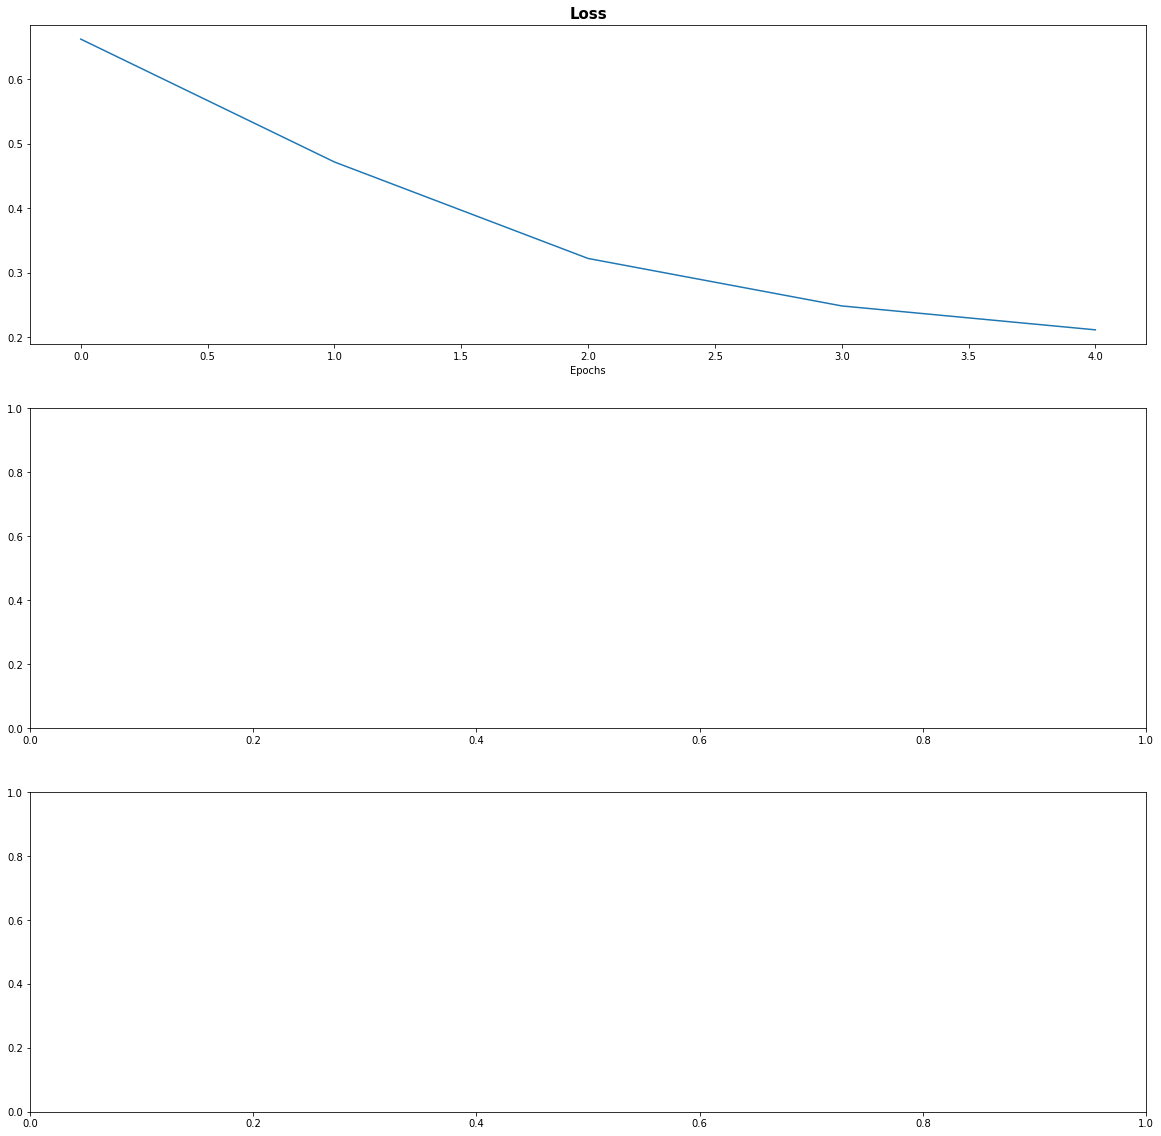

In [17]:
display_training_data(trained)

In [7]:
#  train, test, train_count, test_count = pre_processing()
# visual_test_model(test, model)

In [8]:
# display_training_data(trained)